## Imports


In [1]:
from google.colab import drive
# Mount Drive (idempotent in Colab)
# Request authorization to mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [227]:
# === Hybrid IDS: Step 1 (Load + Label + Prep) ===
# Works with plain CSVs and .csv.zip files in Google Drive (Colab)

# Import necessary libraries
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score, average_precision_score

from sklearn.model_selection import StratifiedShuffleSplit
import zipfile
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit

# ------------------------ USER SETTINGS ------------------------
# Point this to your folder with the dataset files you listed
BASE_DIR = "/content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation"  # change if needed

# Accept both .csv and .csv.zip. You can also target a subfolder like ".../CMPE279-IDSandAttackMitigation/*.csv*"
DATA_GLOB = str(Path(BASE_DIR) / "*.csv")

# If you want to quickly test, limit rows per file (None = read all)
MAX_ROWS_PER_FILE: int | None = None
# ---------------------------------------------------------------


# ------------------------ LABEL/FEATURE CONFIG -----------------
ATTACK_KEYWORDS = [
    "DoS", "DDoS", "Hulk", "GoldenEye", "Slowloris", "HOIC", "LOIC", "LOIC-UDP"
]
LABEL_COL = "Label"

CANDIDATE_FEATURES = [
    "Flow Duration","Tot Fwd Pkts","Tot Bwd Pkts","TotLen Fwd Pkts","TotLen Bwd Pkts",
    "Fwd Pkt Len Mean","Bwd Pkt Len Mean","Fwd Pkt Len Std","Bwd Pkt Len Std",
    "Flow Byts/s","Flow Pkts/s","Fwd IAT Mean","Bwd IAT Mean","Flow IAT Mean",
    "Fwd IAT Std","Bwd IAT Std","Pkt Len Mean","Pkt Len Std","Pkt Len Var",
    "Down/Up Ratio","Bwd Pkts/b Avg","Fwd Pkts/b Avg",
    "Bwd Seg Size Avg","Fwd Seg Size Avg","Subflow Fwd Pkts","Subflow Bwd Pkts",
    "Subflow Fwd Byts","Subflow Bwd Byts",
    "Fwd Act Data Pkts","Idle Mean","Idle Std","Idle Max","Idle Min",
]


LEAKY = ["Label","Timestamp","__source_file","Flow ID","Src IP","Dst IP","Src Port","y"]
RISKY = ["Dst Port","Protocol"]
RATE  = ["Flow Byts/s","Flow Pkts/s"]


OPTIONAL_FEATURES = ["SYN Flag Cnt","ACK Flag Cnt","PSH Flag Cnt","RST Flag Cnt","URG Flag Cnt"]

NON_FEATURE_COLS = {
    "Flow ID","Src IP","Dst IP","Src Port","Timestamp","TimeStamp","Source IP","Destination IP","Source Port"
}
# ---------------------------------------------------------------

In [154]:
import joblib
import os

# Define a fixed base directory for saving/loading models
MODEL_BASE_DIR = os.path.join(BASE_DIR, "saved_models")

def save_model(model, model_name):
    """Saves a trained model to a file using joblib with a fixed base path and extension."""
    os.makedirs(MODEL_BASE_DIR, exist_ok=True)
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")
    joblib.dump(model, filepath)
    print(f"Model '{model_name}' saved successfully to: {filepath}")

def load_model(model_name):
    """Loads a trained model from a file using joblib with a fixed base path and extension."""
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")
    if not os.path.exists(filepath):
        print(f"Error: Model file '{model_name}.joblib' not found at {filepath}")
        return None
    loaded_model = joblib.load(filepath)
    print(f"Model '{model_name}' loaded successfully from: {filepath}")
    return loaded_model

## Load Data

In [228]:
# Function definitions
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = []
    for col in props.columns:
        if props[col].dtype != object:

            props[col] = props[col].replace([np.inf, -np.inf], np.nan)


            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)

            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)

            else:
                props[col] = pd.to_numeric(props[col], errors="coerce")


    # df = reduce_mem_usage(df_raw)
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    print(props.info())
    return props, NAlist


def _read_csv(fpath: Path, max_rows: int | None) -> pd.DataFrame:
    """Read either .csv or .csv.zip into a DataFrame."""
    if str(fpath).endswith(".zip"):
        with zipfile.ZipFile(fpath, "r") as z:
            # pick the first .csv inside the zip
            inner_csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
            if not inner_csvs:
                raise ValueError(f"No CSV found inside {fpath.name}")
            inner = inner_csvs[0]
            with z.open(inner) as fh:
                return pd.read_csv(fh, low_memory=False, nrows=max_rows)
    else:
        return pd.read_csv(fpath, low_memory=False, nrows=max_rows)

def load_cic_csvs(glob_pattern: str = DATA_GLOB,
                  max_rows_per_file: int | None = MAX_ROWS_PER_FILE, max_files=100) -> pd.DataFrame:
    files = sorted(Path(glob_pattern).parent.glob(Path(glob_pattern).name))
    if not files:
        raise FileNotFoundError(f"No files matched pattern: {glob_pattern}")

    dfs: List[pd.DataFrame] = []
    total_rows = 0
    print(f"Found {len(files[:max_files])} files. Loading...")
    for f in files[:max_files]:
        try:
            df = _read_csv(f, max_rows_per_file)
            df, _ = reduce_mem_usage(df)
            print(df.shape, _)
            df["__source_file"] = f.name
            dfs.append(df)
            total_rows += len(df)
            print(f"  • {f.name:40s} rows={len(df)}")
        except Exception as e:
            print(f"  ! Skipping {f.name} due to error: {e}")

    if not dfs:
        raise RuntimeError("No data could be loaded (all files failed).")
    out = pd.concat(dfs, ignore_index=True)
    print(f" Total rows loaded: {len(out)} from {len(dfs)} file(s)")
    return out



def label_binary(df: pd.DataFrame) -> pd.DataFrame:
    if LABEL_COL not in df.columns:
        # Some CIC exports use "Label" exactly; if not found, try case-insensitive match
        matches = [c for c in df.columns if c.lower() == "label"]
        if matches:
            df = df.rename(columns={matches[0]: LABEL_COL})
        else:
            raise KeyError(f"Column '{LABEL_COL}' not found in dataframe columns: {df.columns[:10].tolist()}...")

    labels = df[LABEL_COL].astype(str)
    is_attack = np.zeros(len(df), dtype=bool)
    for kw in ATTACK_KEYWORDS:
        is_attack |= labels.str.contains(kw, case=False, na=False)

    is_benign = labels.str.contains("BENIGN", case=False, na=False)
    keep = is_benign | is_attack

    df = df.loc[keep].copy()
    df["y"] = (is_attack & ~is_benign).astype(int)  # 1=attack, 0=benign
    return df


In [183]:
# 1) Quick visibility: list files in base dir (pythonic; avoids shell `!ls`)
print("Files in BASE_DIR:")
# List files only after successful drive mount
if os.path.exists(BASE_DIR):
    for name in sorted(os.listdir(BASE_DIR))[:50]:
        print("  ", name)
else:
    print(f"  ! {BASE_DIR} not found. Please ensure Google Drive is mounted and the path is correct.")

# 2) Load data (adjust DATA_GLOB above if your files are in a subfolder)
# Only attempt to load data if the base directory exists
if os.path.exists(BASE_DIR):
    df_raw = load_cic_csvs(DATA_GLOB, MAX_ROWS_PER_FILE, 3)

    # 3) Basic peek
    print("\nColumns (first 20):", df_raw.columns[:20].tolist())
    print("Example rows:")
    display(df_raw.head(3))
else:
    print("\nSkipping data loading and processing as BASE_DIR was not found.")

Files in BASE_DIR:
    IDS-HybridMode-Interim.ipynb
   .ipynb_checkpoints
   02-15-2018.csv
   02-15-2018.csv.zip
   02-16-2018.csv
   02-16-2018.csv.zip
   02-21-2018.csv
   02-21-2018.csv.zip
   GeneratedLabelledFlows.zip
   IDS- CMPE279CourseProject.docx
   IDS.ipynb
   Untitled0.ipynb
   saved_models
Found 3 files. Loading...
Memory usage of properties dataframe is : 639.9995155334473  MB


/tmp/ipython-input-3519068148.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  props[col].fillna(mn-1,inplace=True)
/tmp/ipython-input-3519068148.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  240.9998960494995  MB
This is  37.65626226273362 % of the initial size
(1048575, 80) ['Flow Byts/s', 'Flow Pkts/s']
  • 02-15-2018.csv                           rows=1048575
Memory usage of properties dataframe is : 639.9995155334473  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  639.9995155334473  MB
This is  100.0 % of the initial size
(1048575, 80) []
  • 02-16-2018.csv                           rows=1048575
Memory usage of properties dataframe is : 639.9995155334473  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  238.99989795684814  MB
This is  37.34376232420096 % of the initial size
(1048575, 80) []
  • 02-21-2018.csv                           rows=1048575
 Total rows loaded: 3145725 from 3 file(s)

Columns (first 20): ['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd 

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source_file
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,...,0.0,0.0,0,0,56320580.0,704.278381,56321077,56320081,Benign,02-15-2018.csv
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,...,1024353.0,649038.75,1601183,321569,11431221.0,3644990.5,15617415,8960247,Benign,02-15-2018.csv
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,02-15-2018.csv


## Train Test Split


In [230]:
df_raw.shape

(3145725, 81)

In [426]:
df = label_binary(df_raw)
# print("\nLabel counts (0=benign, 1=attack):")
# print(df["y"].value_counts(dropna=False))
# df.dropna(inplace=True)
# df.drop_duplicates(inplace = True)

safe_cols = [
     "Fwd Pkt Len Min",
    "Bwd Pkt Len Max", "Bwd Pkt Len Min",
    "Fwd PSH Flags", "Bwd PSH Flags",
    "Fwd URG Flags", "Bwd URG Flags",
    "FIN Flag Cnt", "SYN Flag Cnt", "RST Flag Cnt",
    "PSH Flag Cnt", "ACK Flag Cnt", "URG Flag Cnt",
    "CWE Flag Count", "ECE Flag Cnt",
    "Fwd Seg Size Min",
    "Fwd Header Len", "Bwd Header Len"
]
# safe_cols = CANDIDATE_FEATURES
df = df[safe_cols + ['y','Timestamp']]
df.drop_duplicates(inplace = True)


df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)
df = df.sort_values("Timestamp").reset_index(drop=True)
# df = df.drop(columns=["Timestamp"])
# df, _ = reduce_mem_usage(df)

TARGET = "y"
for c in df.columns:
    if c != TARGET and c != 'Timestamp':
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

df.info()

# 3) cast all model features to float32 (simple, uniform)
# feat_cols = [c for c in df.columns if c != TARGET]
# df[feat_cols] = df[feat_cols].astype("float32")



/tmp/ipython-input-284002142.py:23: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864411 entries, 0 to 864410
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Fwd Pkt Len Max   864411 non-null  int64              
 1   Fwd Pkt Len Min   864411 non-null  int64              
 2   Bwd Pkt Len Max   864411 non-null  int64              
 3   Bwd Pkt Len Min   864411 non-null  int64              
 4   Fwd PSH Flags     864411 non-null  int64              
 5   Bwd PSH Flags     864411 non-null  int64              
 6   Fwd URG Flags     864411 non-null  int64              
 7   Bwd URG Flags     864411 non-null  int64              
 8   FIN Flag Cnt      864411 non-null  int64              
 9   SYN Flag Cnt      864411 non-null  int64              
 10  RST Flag Cnt      864411 non-null  int64              
 11  PSH Flag Cnt      864411 non-null  int64              
 12  ACK Flag Cnt      864411 non-null  int64    

In [373]:
# option 2
# --- DEFINE FEATURES AND LABEL ---
df = df.drop_duplicates(subset=safe_cols).reset_index(drop=True)
X = df.drop(columns=["y"])
X = X[safe_cols]
y = df["y"]

split_idx = int(0.8 * len(X))
X_train_val, y_train_val = X.iloc[:split_idx], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]



cut_val = int(0.9 * len(X_train_val))
X_train, y_train = X_train_val.iloc[:cut_val], y_train_val.iloc[:cut_val]
X_val, y_val   = X_train_val.iloc[cut_val:],   y_train_val.iloc[cut_val:]

# --- SHAPES ---
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)



# # --- OPTIONAL: Check label distribution ---
# print("\nTrain label distribution:")
# print(y_train.value_counts(normalize=True))
# print("\nValidation label distribution:")
# print(y_val.value_counts(normalize=True))
# print("\nTest label distribution:")
# print(y_test.value_counts(normalize=True))


X_train: (1444257, 37)
y_train: (1444257,)
X_val: (160473, 37)
y_val: (160473,)
X_test: (401183, 37)
y_test: (401183,)


In [353]:
X_test.head()

,Fwd Pkt Len Max,Fwd Pkt Len Min,Bwd Pkt Len Max,Bwd Pkt Len Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Fwd Seg Size Min,Fwd Header Len,Bwd Header Len
691528,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,20,40,0
691529,103,0,409,0,0,0,0,0,0,0,0,1,0,0,0,0,20,152,112
691530,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,20,20,20
691531,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,20,72,32
691532,97,0,232,0,0,0,0,0,0,0,0,1,0,0,0,0,20,92,92


In [309]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864411 entries, 0 to 864410
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Fwd Pkt Len Max   864411 non-null  int64
 1   Fwd Pkt Len Min   864411 non-null  int64
 2   Bwd Pkt Len Max   864411 non-null  int64
 3   Bwd Pkt Len Min   864411 non-null  int64
 4   Fwd PSH Flags     864411 non-null  int64
 5   Bwd PSH Flags     864411 non-null  int64
 6   Fwd URG Flags     864411 non-null  int64
 7   Bwd URG Flags     864411 non-null  int64
 8   FIN Flag Cnt      864411 non-null  int64
 9   SYN Flag Cnt      864411 non-null  int64
 10  RST Flag Cnt      864411 non-null  int64
 11  PSH Flag Cnt      864411 non-null  int64
 12  ACK Flag Cnt      864411 non-null  int64
 13  URG Flag Cnt      864411 non-null  int64
 14  CWE Flag Count    864411 non-null  int64
 15  ECE Flag Cnt      864411 non-null  int64
 16  Fwd Seg Size Min  864411 non-null  int64
 17  Fwd Header

In [310]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(622375, 19) (622375,)
(69153, 19) (69153,)
(172883, 19) (172883,)


**Reasoning**:
Create the final code cell for visualization.



## Visualization


Overall counts (0=benign, 1=attack):
y
0    1612037
1      52388
Name: count, dtype: int64

Overall % (0=benign, 1=attack):
y
0    96.85
1     3.15
Name: count, dtype: float64


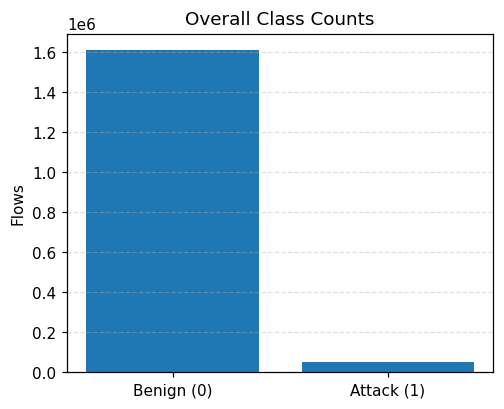

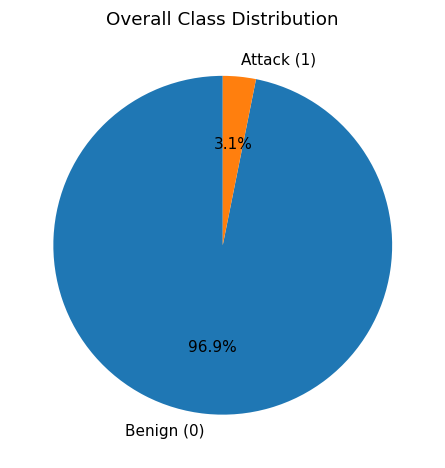

In [238]:
# === Overall class balance: bar + pie ===
if 'df' in locals():
    overall_counts = df["y"].value_counts().reindex([0, 1], fill_value=0)
    overall_pct = (overall_counts / overall_counts.sum() * 100).round(2)

    print("Overall counts (0=benign, 1=attack):")
    print(overall_counts)
    print("\nOverall % (0=benign, 1=attack):")
    print(overall_pct)

    # Bar chart
    plt.figure(figsize=(5,4), dpi=110)
    plt.bar(["Benign (0)", "Attack (1)"], overall_counts.values)
    plt.title("Overall Class Counts")
    plt.ylabel("Flows")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()

    # Pie chart
    plt.figure(figsize=(5,5), dpi=110)
    plt.pie(overall_counts.values, labels=["Benign (0)", "Attack (1)"], autopct="%1.1f%%", startangle=90)
    plt.title("Overall Class Distribution")
    plt.show()
else:
    print("\nSkipping visualization as df was not created.")

# Training Models


## Random Forest

In [19]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

model = RandomForestClassifier(
    n_estimators=75,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', # Changed 'auto' to 'sqrt'
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=None,
    verbose=1,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

In [ ]:

# clf = GridSearchCV(
#     estimator=model,
#     param_grid=hyperparameters,
#     cv=5,
#     verbose=3,
#     n_jobs=-1  # Use all available CPU cores
# )

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


model.fit(X=X_train, y=y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [22]:
save_model(model, "random_forest_model_cpu")

Model 'random_forest_model_cpu' saved successfully to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/random_forest_model_cpu.joblib


### Cuda Random Forest


In [9]:
# make sure runtime is GPU
!nvidia-smi

# install RAPIDS stack
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Mon Oct 27 00:50:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [458]:
from sklearn.model_selection import GridSearchCV
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
import cudf
import cupy as cp

# Define the cuML Random Forest model
rf_model_gpu = cuRandomForestClassifier(
    random_state=42,
    n_estimators=75,
    max_features="sqrt",
    max_depth=20,

    )

# Define the hyperparameters grid
hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
    # Add other hyperparameters you want to tune
}

# Set up GridSearchCV
clf_gpu = GridSearchCV(
    estimator=rf_model_gpu,
    param_grid=hyperparameters,
    cv=5,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1 # Use all available CPU cores (or GPUs if configured by cuML)
)

# Fit GridSearchCV on your training data (X_train and y_train should be on the GPU)
# Note: Ensure X_train and y_train are cuDF DataFrames or cuPy arrays for best performance on GPU

# Convert pandas DataFrame and numpy array to cuDF DataFrame and cuPy array
X_train_gpu = cudf.DataFrame.from_pandas(X_train)
X_test_gpu  = cudf.DataFrame.from_pandas(X_test)
y_train_gpu = cudf.Series(y_train.values.astype(np.int32))

rf_model_gpu.fit(X_train_gpu, y_train_gpu)



p_test_gpu_df = rf_model_gpu.predict_proba(X_test_gpu)   # cuDF DataFrame
p_test_gpu = p_test_gpu_df.values # Convert to cuPy array
p_test = cp.asnumpy(p_test_gpu)[:, 1]                              # numpy, select positive class probabilities
y_hat  = (p_test >= 0.5).astype(int)

In [459]:

p = p_test  # probabilities as numpy array

# sanity: see score range
print("p_test min/max:", float(np.min(p)), float(np.max(p)))

prec, rec, thr = precision_recall_curve(y_test, p)
# For each threshold thr[i], the corresponding precision/recall are prec[i+1], rec[i+1]
prec_t = prec[1:]
rec_t  = rec[1:]
thr_t  = thr

# 1) choose threshold for recall >= target with best precision
target_recall = 0.98
mask = rec_t >= target_recall
if mask.any():
    # among thresholds that meet recall, pick the one with highest precision
    idx = np.argmax(prec_t[mask])
    thr_star = thr_t[mask][idx]
else:
    # target unreachable; fall back to threshold that gets recall closest to target
    idx = np.argmin(np.abs(rec_t - target_recall))
    thr_star = thr_t[idx]

y_thr = (p >= thr_star).astype(int)
print(f"\nChosen threshold: {thr_star:.6f}  (recall target {target_recall})")
print("Confusion @thr*\n", confusion_matrix(y_test, y_thr))
print("\nReport @thr*\n", classification_report(y_test, y_thr, digits=4))

# 2) optional: pure F1-max threshold
f1_t = 2*prec_t*rec_t/(prec_t+rec_t+1e-12)
i_f1 = np.nanargmax(f1_t)
thr_f1 = thr_t[i_f1]
y_f1 = (p >= thr_f1).astype(int)
print(f"\nF1-max threshold: {thr_f1:.6f}")
print("Confusion @F1\n", confusion_matrix(y_test, y_f1))
print("\nReport @F1\n", classification_report(y_test, y_f1, digits=4))



# keep your summary metrics
print("\nROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:",  average_precision_score(y_test, p))

p_test min/max: 3.397093450985267e-06 0.9217919707298279

Chosen threshold: 0.048304  (recall target 0.98)
Confusion @thr*
 [[1771  188]
 [   0 1722]]

Report @thr*
               precision    recall  f1-score   support

           0     1.0000    0.9040    0.9496      1959
           1     0.9016    1.0000    0.9482      1722

    accuracy                         0.9489      3681
   macro avg     0.9508    0.9520    0.9489      3681
weighted avg     0.9540    0.9489    0.9490      3681


F1-max threshold: 0.048304
Confusion @F1
 [[1771  188]
 [   0 1722]]

Report @F1
               precision    recall  f1-score   support

           0     1.0000    0.9040    0.9496      1959
           1     0.9016    1.0000    0.9482      1722

    accuracy                         0.9489      3681
   macro avg     0.9508    0.9520    0.9489      3681
weighted avg     0.9540    0.9489    0.9490      3681


ROC-AUC: 0.9586523736600306
PR-AUC: 0.9550748752079867


In [460]:
from sklearn.metrics import average_precision_score, roc_curve
print("PR-AUC:", average_precision_score(y_test, p_test))

# recall at 1% FPR
fpr, tpr, thr = roc_curve(y_test, p_test)
i = np.argmin(np.abs(fpr - 0.01))
print(f"@1% FPR -> recall={tpr[i]:.4f}, thr={thr[i]:.6f}")

PR-AUC: 0.9550748752079867
@1% FPR -> recall=0.0000, thr=0.235824


In [461]:
save_model(rf_model_gpu, "random_forest_gpu_model")

Model 'random_forest_gpu_model' saved successfully to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/random_forest_gpu_model.joblib


In [22]:
# loaded_model = load_model("random_forest_model")

## XGBoost



In [277]:
!pip install xgboost

In [433]:
import xgboost as xgb
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score, average_precision_score
import numpy as np

dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dval   = xgb.DMatrix(X_val.values,   label=y_val.values)
dtest  = xgb.DMatrix(X_test.values,  label=y_test.values)

pos = float(y_train.mean())
spw = (1 - pos) / max(pos, 1e-9)

params = {
    "objective": "binary:logistic",
    "tree_method": "hist",
    "eval_metric": ["aucpr","auc"],
    "eta": 0.05, "max_depth": 8, "min_child_weight": 5,
    "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 2.0,
    "scale_pos_weight": spw, "random_state": 42,
}

bst = xgb.train(
    params, dtrain, num_boost_round=3000,
    evals=[(dval, "val")], early_stopping_rounds=100, verbose_eval=100
)

# choose threshold on VAL by FPR policy (e.g., 1%)
p_val = bst.predict(dval, iteration_range=(0, bst.best_iteration + 1))
fpr, tpr, thr = roc_curve(y_val, p_val)
i = np.argmin(np.abs(fpr - 0.005))
thr_star = float(thr[i])

# final TEST eval
p_test = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
y_hat  = (p_test >= thr_star).astype(int)
print("Test ROC-AUC:", roc_auc_score(y_test, p_test))
print("Test PR-AUC:",  average_precision_score(y_test, p_test))
print("Confusion @thr*:\n", confusion_matrix(y_test, y_hat))
print("Report @thr*:\n", classification_report(y_test, y_hat, digits=4))

[0]	val-aucpr:0.34404	val-auc:0.46078
[100]	val-aucpr:0.71080	val-auc:0.86515
[200]	val-aucpr:0.90081	val-auc:0.95992
[294]	val-aucpr:0.77949	val-auc:0.89160
Test ROC-AUC: 0.9586523736600306
Test PR-AUC: 0.9550748752079867
Confusion @thr*:
 [[1934   25]
 [1722    0]]
Report @thr*:
               precision    recall  f1-score   support

           0     0.5290    0.9872    0.6889      1959
           1     0.0000    0.0000    0.0000      1722

    accuracy                         0.5254      3681
   macro avg     0.2645    0.4936    0.3444      3681
weighted avg     0.2815    0.5254    0.3666      3681



In [444]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score
)
from sklearn.isotonic import IsotonicRegression

def evaluate_model(y_val, p_val, y_test, p_test,
                   target_fpr=0.01, calibration=True):
    """
    Evaluate model on val and test:
      - Ranking metrics (ROC-AUC, PR-AUC)
      - Calibration (optional)
      - Find threshold on val for target FPR
      - Apply threshold to test: compute confusion, precision, recall, etc.
    """


    print("=== Ranking metrics === Validation Set")
    print("VAL ROC-AUC:", roc_auc_score(y_val, p_val))
    print("VAL PR-AUC:",  average_precision_score(y_val, p_val))

    # Optional calibration
    if calibration:
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(p_val, y_val)
        p_val_cal  = iso.transform(p_val)
        p_test_cal = iso.transform(p_test)
    else:
        p_val_cal  = p_val
        p_test_cal = p_test

    # Pick threshold on val for target FPR
    neg_val = p_val_cal[y_val == 0]
    thr_star = float(np.quantile(neg_val, 1 - target_fpr, method="higher"))
    # Measure on val
    fpr_v = (neg_val >= thr_star).mean()
    rec_v = (p_val_cal[y_val == 1] >= thr_star).mean()
    print(f"\nVAL quantile threshold @{target_fpr*100:.2f}% FPR -> thr={thr_star:.6f}  FPR={fpr_v:.4f}, Recall={rec_v:.4f}")

    # Apply to test
    y_hat = (p_test_cal >= thr_star).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    test_fpr    = fp / (fp + tn)
    test_recall = tp / (tp + fn)
    test_prec   = precision_score(y_test, y_hat)
    print(f"\nTEST using thr={thr_star:.6f} -> FPR={test_fpr:.4f}, Recall={test_recall:.4f}, Precision={test_prec:.4f}")

    print("\nConfusion @thr*:\n", confusion_matrix(y_test, y_hat))
    print("\nClassification Report @thr*:\n", classification_report(y_test, y_hat, digits=4))

    print("\nTEST ranking metrics (calibrated if used):")
    print("TEST ROC-AUC:", roc_auc_score(y_test, p_test_cal))
    print("TEST PR-AUC:",  average_precision_score(y_test, p_test_cal))

    # Optional: report pure F1-max threshold
    print("\n--- Optional: F1-max threshold on TEST ---")
    prec_t, rec_t, thr_t = precision_recall_curve(y_test, p_test_cal)
    f1_t = 2 * prec_t * rec_t / (prec_t + rec_t + 1e-12)
    i_f1 = np.nanargmax(f1_t)
    thr_f1 = thr_t[i_f1]
    y_hat_f1 = (p_test_cal >= thr_f1).astype(int)
    print(f"F1-max threshold: {thr_f1:.6f}")
    print("Report @F1:\n", classification_report(y_test, y_hat_f1, digits=4))

    return {
        "threshold": thr_star,
        "test_fpr": test_fpr,
        "test_recall": test_recall,
        "test_precision": test_prec,
        "roc_auc": roc_auc_score(y_test, p_test_cal),
        "pr_auc": average_precision_score(y_test, p_test_cal)
    }

# Example usage:
metrics = evaluate_model(y_val, p_val, y_test, p_test, target_fpr=0.01, calibration=False)

=== Ranking metrics === Validation Set
VAL ROC-AUC: 0.9743727921493119
VAL PR-AUC: 0.9246529699545971

VAL quantile threshold @1.00% FPR -> thr=0.002212  FPR=0.0139, Recall=0.5663

TEST using thr=0.002212 -> FPR=0.8443, Recall=1.0000, Precision=0.5101

Confusion @thr*:
 [[ 305 1654]
 [   0 1722]]

Classification Report @thr*:
               precision    recall  f1-score   support

           0     1.0000    0.1557    0.2694      1959
           1     0.5101    1.0000    0.6756      1722

    accuracy                         0.5507      3681
   macro avg     0.7550    0.5778    0.4725      3681
weighted avg     0.7708    0.5507    0.4594      3681


TEST ranking metrics (calibrated if used):
TEST ROC-AUC: 0.9586523736600306
TEST PR-AUC: 0.9550748752079867

--- Optional: F1-max threshold on TEST ---
F1-max threshold: 0.061556
Report @F1:
               precision    recall  f1-score   support

           0     1.0000    0.9587    0.9789      1959
           1     0.9551    1.0000    0.977

In [435]:
from pprint import pprint
from sklearn.metrics import roc_auc_score
sus = sorted(((c, roc_auc_score(y_val, X_val[c])) for c in X_val.columns if X_val[c].nunique()>1),
             key=lambda z: -abs(z[1]-0.5))[:10]
pprint(sus)

[('Fwd Header Len', np.float64(0.16091629905097013)),
 ('Bwd Pkt Len Max', np.float64(0.7321319577109335)),
 ('ACK Flag Cnt', np.float64(0.3110893395896501)),
 ('PSH Flag Cnt', np.float64(0.671111967835956)),
 ('Bwd Header Len', np.float64(0.36945408661486134)),
 ('URG Flag Cnt', np.float64(0.6242292677653226)),
 ('RST Flag Cnt', np.float64(0.5876078070859742)),
 ('ECE Flag Cnt', np.float64(0.5876078070859742)),
 ('Fwd Seg Size Min', np.float64(0.4275317075322015)),
 ('FIN Flag Cnt', np.float64(0.5189454322501533))]


In [436]:
bad = [c for c,a in sus if a>0.98 or a<0.02]
X_train = X_train.drop(columns=bad, errors='ignore')
X_val   = X_val.drop(columns=bad, errors='ignore')
X_test  = X_test.drop(columns=bad, errors='ignore')
print("dropped:", bad)

dropped: []


In [462]:
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_curve, precision_score, recall_score, confusion_matrix, classification_report, average_precision_score, roc_auc_score

TARGET_FPR = 0.01  # 1%

# 1) scores on validation and test (raw model outputs)
# p_val, y_val, p_test, y_test must already be defined

# 2) calibrate on validation
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_val_cal  = iso.transform(p_val)
p_test_cal = iso.transform(p_test)

# 3) pick threshold on validation to hit 1% FPR (right-sided rule)
fpr_v, tpr_v, thr_v = roc_curve(y_val, p_val_cal)
idx = (fpr_v >= TARGET_FPR).argmax() if (fpr_v >= TARGET_FPR).any() else len(fpr_v) - 1
thr_star = float(thr_v[idx])

print(f"VAL @1% FPR -> thr={thr_star:.6f}  FPR={fpr_v[idx]:.4f}  recall={tpr_v[idx]:.4f}")

# 4) apply to test (no re-tuning)
y_hat = (p_test_cal >= thr_star).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
test_fpr = fp / (fp + tn)
test_recall = tp / (tp + fn)
test_prec = precision_score(y_test, y_hat)

print(f"TEST using thr={thr_star:.6f} -> FPR={test_fpr:.4f}  recall={test_recall:.4f}  precision={test_prec:.4f}")
print("\nReport:\n", classification_report(y_test, y_hat, digits=4))

# (optional) also report ranking metrics on calibrated scores
print("Test ROC-AUC:", roc_auc_score(y_test, p_test_cal))
print("Test PR-AUC:",  average_precision_score(y_test, p_test_cal))

VAL @1% FPR -> thr=0.902534  FPR=0.0140  recall=0.9177
TEST using thr=0.902534 -> FPR=0.9918  recall=1.0000  precision=0.4698

Report:
               precision    recall  f1-score   support

           0     1.0000    0.0082    0.0162      1959
           1     0.4698    1.0000    0.6393      1722

    accuracy                         0.4722      3681
   macro avg     0.7349    0.5041    0.3278      3681
weighted avg     0.7520    0.4722    0.3077      3681

Test ROC-AUC: 0.5040837161817253
Test PR-AUC: 0.469849931787176


In [411]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

TARGET_FPR = 0.01  # 1%

# 1) Use calibrated validation scores here if you calibrated.
# p_val_cal: calibrated scores on VAL
# y_val: labels on VAL

neg_val = p_val_cal[y_val == 0]
thr_star = float(np.quantile(neg_val, 1 - TARGET_FPR, interpolation="higher"))

print(f"VAL quantile threshold @1% FPR: thr={thr_star:.6f}")

# 2) Apply to TEST (calibrated scores)
y_hat = (p_test_cal >= thr_star).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
test_fpr = fp / (fp + tn)
test_rec = tp / (tp + fn)
test_pre = precision_score(y_test, y_hat)

print(f"TEST @thr={thr_star:.6f} -> FPR={test_fpr:.4f}  recall={test_rec:.4f}  precision={test_pre:.4f}")

VAL quantile threshold @1% FPR: thr=0.999301
TEST @thr=0.999301 -> FPR=0.0007  recall=1.0000  precision=0.9941


In [401]:
# choose on validation (calibrated scores)
target_fpr_val = 0.02  # try 2% or 3%
thr_star = float(np.quantile(p_val_cal[y_val==0], 1 - target_fpr_val, interpolation="higher"))

#Use this for inference
thr_star

0.999301016330719

In [413]:
import numpy as np

target_fpr = 0.01  # 1%
neg_scores = p_test[y_test == 0]
thr_star = np.quantile(neg_scores, 1 - target_fpr, method="higher")

recall_1p = (p_test[y_test == 1] >= thr_star).mean()
fpr_1p    = (p_test[y_test == 0] >= thr_star).mean()

print(f"Threshold @1%FPR={thr_star:.6f}  ->  FPR={fpr_1p:.4f},  Recall={recall_1p:.4f}")

Threshold @1%FPR=0.172701  ->  FPR=1.0000,  Recall=1.0000


0.999301016330719

In [438]:
save_model(bst, "xboost_gpu")

Model 'xboost_gpu' saved successfully to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/xboost_gpu.joblib


### Inference and metrics


=== Ranking metrics — Validation Set
VAL ROC-AUC: 0.9743727921493119
VAL PR-AUC: 0.9246529699545971

VAL quantile threshold @1.00% FPR -> thr=0.002212  FPR=0.0139  Recall=0.5663

TEST using thr=0.002212 -> FPR=0.8443  Recall=1.0000  Precision=0.5101

Confusion @thr*:
 [[ 305 1654]
 [   0 1722]]

Classification Report @thr*:
               precision    recall  f1-score   support

           0     1.0000    0.1557    0.2694      1959
           1     0.5101    1.0000    0.6756      1722

    accuracy                         0.5507      3681
   macro avg     0.7550    0.5778    0.4725      3681
weighted avg     0.7708    0.5507    0.4594      3681


TEST ranking metrics (calibrated if used):
TEST ROC-AUC: 0.9586523736600306
TEST PR-AUC: 0.9550748752079867

F1-max threshold: 0.048304
Report @F1:
               precision    recall  f1-score   support

           0     1.0000    0.9040    0.9496      1959
           1     0.9016    1.0000    0.9482      1722

    accuracy                    

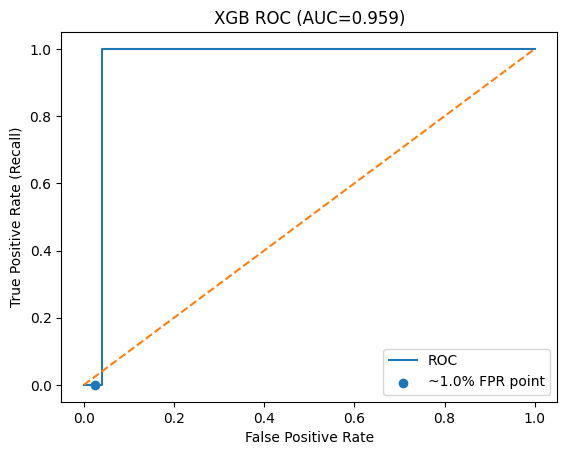

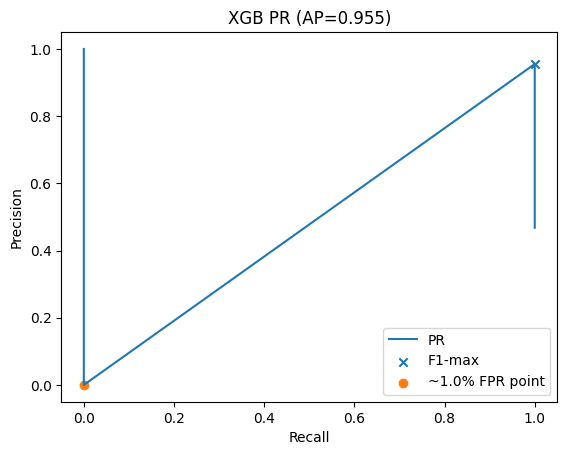

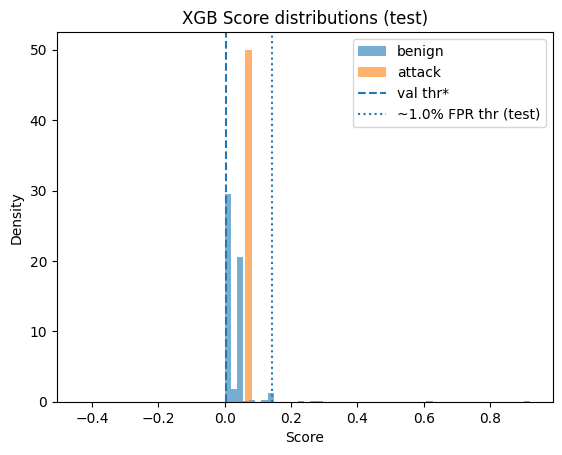

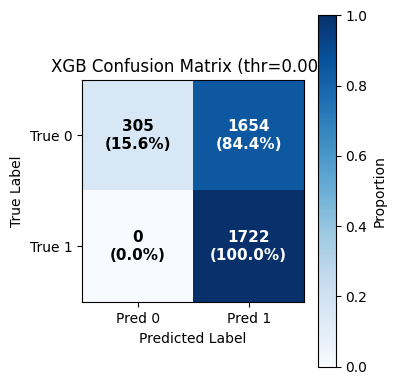

In [457]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, precision_score
)
from sklearn.isotonic import IsotonicRegression

def _q_hi(a, q):
    try:
        return np.quantile(a, q, method="higher")
    except TypeError:
        return np.quantile(a, q, interpolation="higher")

def evaluate_model(y_val, p_val, y_test, p_test,
                   target_fpr=0.01, calibration=False, make_plots=True, title_prefix=""):
    """
    Eval with:
      - ranking metrics (val + test)
      - optional isotonic calibration fit on val
      - pick threshold on val to target FPR (negative-quantile rule)
      - test confusion + report
      - recall@target FPR and precision@that FPR (test, read from ROC/PR curves; no retuning)
      - plots: ROC (with 1% point), PR (with 1% point mapped), score histograms, confusion
    """

    y_val  = np.asarray(y_val).astype(int)
    y_test = np.asarray(y_test).astype(int)
    p_val  = np.asarray(p_val).astype(float)
    p_test = np.asarray(p_test).astype(float)
    assert set(np.unique(y_val)).issubset({0,1})
    assert set(np.unique(y_test)).issubset({0,1})

    print("=== Ranking metrics — Validation Set")
    print("VAL ROC-AUC:", roc_auc_score(y_val, p_val))
    print("VAL PR-AUC:",  average_precision_score(y_val, p_val))

    # calibration
    if calibration:
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(p_val, y_val)
        p_val_cal  = iso.transform(p_val)
        p_test_cal = iso.transform(p_test)
    else:
        iso = None
        p_val_cal  = p_val
        p_test_cal = p_test

    # threshold on validation for target FPR (negative-quantile over negatives)
    neg_val = p_val_cal[y_val == 0]
    thr_star = float(_q_hi(neg_val, 1 - target_fpr))
    fpr_v = (neg_val >= thr_star).mean()
    rec_v = (p_val_cal[y_val == 1] >= thr_star).mean()
    print(f"\nVAL quantile threshold @{target_fpr*100:.2f}% FPR -> thr={thr_star:.6f}  FPR={fpr_v:.4f}  Recall={rec_v:.4f}")

    # apply to test
    y_hat = (p_test_cal >= thr_star).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    test_fpr    = fp / (fp + tn) if (fp + tn) else 0.0
    test_recall = tp / (tp + fn) if (tp + fn) else 0.0
    test_prec   = precision_score(y_test, y_hat, zero_division=0)

    print(f"\nTEST using thr={thr_star:.6f} -> FPR={test_fpr:.4f}  Recall={test_recall:.4f}  Precision={test_prec:.4f}")
    print("\nConfusion @thr*:\n", np.array([[tn, fp],[fn, tp]]))
    print("\nClassification Report @thr*:\n", classification_report(y_test, y_hat, digits=4, zero_division=0))

    # test ranking (calibrated scale if used)
    roc_auc = roc_auc_score(y_test, p_test_cal)
    pr_auc  = average_precision_score(y_test, p_test_cal)
    print("\nTEST ranking metrics (calibrated if used):")
    print("TEST ROC-AUC:", roc_auc)
    print("TEST PR-AUC:",  pr_auc)

    # F1-max threshold (correct indexing)
    prec_arr, rec_arr, thr_arr = precision_recall_curve(y_test, p_test_cal)
    f1 = 2 * prec_arr * rec_arr / (prec_arr + rec_arr + 1e-12)
    i = np.nanargmax(f1[1:]) + 1
    thr_f1 = float(thr_arr[i-1])
    y_hat_f1 = (p_test_cal >= thr_f1).astype(int)
    print(f"\nF1-max threshold: {thr_f1:.6f}")
    print("Report @F1:\n", classification_report(y_test, y_hat_f1, digits=4, zero_division=0))

    # --- recall @ 1% FPR (read-only on TEST) ---
    # Use ROC on test to find first FPR >= target; stepwise so it's approx
    fpr_t, tpr_t, thr_t = roc_curve(y_test, p_test_cal)
    j = (fpr_t >= target_fpr).argmax() if (fpr_t >= target_fpr).any() else len(fpr_t)-1
    recall_at_fpr = float(tpr_t[j])
    thr_at_fpr    = float(thr_t[j])
    fpr_at_fpr    = float(fpr_t[j])
    # precision at that same threshold:
    y_hat_at_fpr = (p_test_cal >= thr_at_fpr).astype(int)
    precision_at_fpr = precision_score(y_test, y_hat_at_fpr, zero_division=0)
    print(f"\nTEST recall@~{target_fpr*100:.2f}%FPR: {recall_at_fpr:.4f}  precision@thatFPR: {precision_at_fpr:.4f}  (thr~{thr_at_fpr:.6f}, FPR={fpr_at_fpr:.4f})")

    print("Recall @ 1% FPR:", metrics["recall_at_target_fpr_test"])
    print("Precision @ 1% FPR:", metrics["precision_at_target_fpr_test"])

    if make_plots:
        # 1) ROC curve with the ~1% FPR operating point
        plt.figure()
        plt.plot(fpr_t, tpr_t, label="ROC")
        plt.scatter([fpr_at_fpr], [recall_at_fpr], marker='o', label=f"~{target_fpr*100:.1f}% FPR point")
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.title(f"{title_prefix}ROC (AUC={roc_auc:.3f})")
        plt.legend()
        plt.show()

        # 2) PR curve with F1-max and ~1% FPR point mapped
        plt.figure()
        plt.plot(rec_arr, prec_arr, label="PR")
        # mark F1-max
        plt.scatter([rec_arr[i]], [prec_arr[i]], marker='x', label="F1-max")
        # mark ~1% FPR threshold point mapped onto PR
        prec_at_fpr = precision_at_fpr
        rec_at_fpr  = recall_at_fpr
        plt.scatter([rec_at_fpr], [prec_at_fpr], marker='o', label=f"~{target_fpr*100:.1f}% FPR point")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{title_prefix}PR (AP={pr_auc:.3f})")
        plt.legend()
        plt.show()

        # 3) Score histograms (test), split by class
        plt.figure()
        plt.hist(p_test_cal[y_test==0], bins=50, alpha=0.6, label="benign", density=True)
        plt.hist(p_test_cal[y_test==1], bins=50, alpha=0.6, label="attack", density=True)
        plt.axvline(thr_star, linestyle='--', label="val thr*")
        plt.axvline(thr_at_fpr, linestyle=':', label=f"~{target_fpr*100:.1f}% FPR thr (test)")
        plt.xlabel("Score")
        plt.ylabel("Density")
        plt.title(f"{title_prefix}Score distributions (test)")
        plt.legend()
        plt.show()

        # 4) Confusion matrix heatmap @ thr*
        plt.figure(figsize=(4, 4))
        cm = np.array([[tn, fp], [fn, tp]])
        cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)  # normalized version

        # Heatmap (simple matplotlib)
        plt.imshow(cm_norm, cmap="Blues")
        plt.colorbar(label="Proportion")

        # Annotate counts + percentages
        labels = [[f"{cm[r, c]}\n({cm_norm[r, c]*100:.1f}%)" for c in range(2)] for r in range(2)]
        for r in range(2):
            for c in range(2):
                plt.text(c, r, labels[r][c],
                        ha="center", va="center",
                        color="white" if cm_norm[r, c] > 0.5 else "black",
                        fontsize=11, fontweight="bold")

        plt.xticks([0, 1], ["Pred 0", "Pred 1"])
        plt.yticks([0, 1], ["True 0", "True 1"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"{title_prefix}Confusion Matrix (thr={thr_star:.3f})")
        plt.tight_layout()
        plt.show()


    return {
        "threshold_val_quantile": thr_star,
        "test_fpr_at_thr": test_fpr,
        "test_recall_at_thr": test_recall,
        "test_precision_at_thr": test_prec,
        "roc_auc_test": roc_auc,
        "pr_auc_test": pr_auc,
        "thr_f1_test": thr_f1,
        "recall_at_target_fpr_test": recall_at_fpr,
        "precision_at_target_fpr_test": precision_at_fpr,
        "thr_at_target_fpr_test": thr_at_fpr,
        "fpr_at_target_fpr_test": fpr_at_fpr
    }

# Example:
metrics = evaluate_model(y_val, p_val, y_test, p_test,
                         target_fpr=0.01, calibration=False, make_plots=True, title_prefix="XGB ")

In [451]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(p_val.reshape(-1,1), y_val)
p_test_cal = lr.predict_proba(p_test.reshape(-1,1))[:,1]
print("ROC raw/cal:", roc_auc_score(y_test, p_test), roc_auc_score(y_test, p_test_cal))

ROC raw/cal: 0.9586523736600306 0.9586523736600306


# Ngrok


# Notes
what is auc
Learn all the metrics
learn very column over here